> unet_seg.py
* reads the segmented masks, ground truths from the folders
* u-net training
* loading trained model weights
* generating predicted masks
* dice score calculation

### imports

In [1]:
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.models import load_model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution1D
from keras.datasets import imdb
from keras import backend as K
import pickle as pkl
import cv2

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### loading models

In [2]:
from zf_unet_224_model import ZF_UNET_224, dice_coef_loss, dice_coef
from keras.optimizers import Adam
from keras.models import load_model, model_from_json
model = ZF_UNET_224()
optim = Adam()
model.compile(optimizer=optim, loss=dice_coef_loss, metrics=[dice_coef, dice_coef_loss])


In [3]:
from zf_unet_224_model import ZF_UNET_224, dice_coef_loss, dice_coef
from keras.optimizers import Adam
from keras.utils.generic_utils import get_custom_objects
mp = 'zf_unet_224_temp.h5'
model = load_model(mp, custom_objects={'dice_coef_loss': dice_coef_loss,'dice_coef': dice_coef})

In [78]:
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display, Markdown, Latex
import tensorflow as tf

### experimenting with a sample

In [81]:
tr_img_path = os.path.join('data_seg', 'test', 'image')
tr_mask_path = os.path.join('data_seg', 'test', 'label')
img_id = 12
img_path = os.path.join(tr_img_path,str(img_id)+'.png')
a = cv2.imread(img_path)
a = cv2.resize(a, (224, 224)) 

In [82]:
a.shape

(224, 224, 3)

In [83]:
a = np.matrix.astype(a,dtype='float64')
#print(a)

In [84]:
a /= 255
a -= 0.5

In [10]:
#print(a)

In [85]:
a = np.expand_dims(a,0)

In [86]:
res = model.predict(a)

In [87]:
res.shape

(1, 224, 224, 1)

In [88]:
res  = np.squeeze(res,axis=0)
res.shape

(224, 224, 1)

In [89]:
res  = np.squeeze(res,axis=-1)
res.shape

(224, 224)

In [90]:
import matplotlib.pyplot as plt

In [91]:
#print(res)
r, c = res.shape
for i in range(r):
    for j in range(c):
        if res[i,j] <= 0.5:
            res[i,j] = 0.0
        else:
            res[i,j] = 1.0
print(res.max())
print(res.min())

1.0
0.0


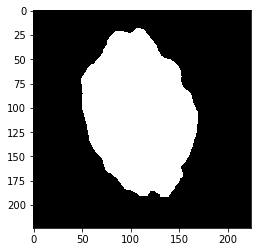

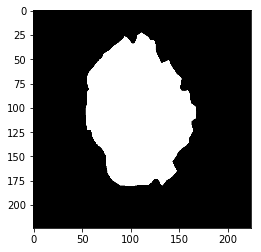

In [92]:
plt.imshow(res, cmap='gray')
plt.show()
mask_path = os.path.join(tr_mask_path,str(img_id)+'.png')
b = cv2.imread(mask_path,0)
b = cv2.resize(b, (224, 224)) 
plt.imshow(b, cmap='gray')
plt.show()

In [93]:
b = np.matrix.astype(b,dtype='float64')
r, c = b.shape
for i in range(r):
    for j in range(c):
        if b[i,j] <= 255/2:
            b[i,j] = 0.0
        else:
            b[i,j] = 1.0

In [49]:
def dice_coef(y_true, y_pred):
    y_p = y_pred.flatten()
    #print(y_p.shape)
    y_b = y_true.flatten()
    #print(y_b.shape)
    cc = np.dot(y_p,y_b)
    #print(cc)
    ps = np.sum(y_p)
    pb = np.sum(y_b)
    ds = (2.0*cc + 1.0)/(ps+pb+1)
    #print(type(ds))
    return ds


In [59]:
def pred_mask(id, show = False, save = False):
    tr_img_path = os.path.join('data_seg', 'test', 'image')
    tr_mask_path = os.path.join('data_seg', 'test', 'label')
    img_id = id
    img_path = os.path.join(tr_img_path,str(img_id)+'.png')
    a = cv2.imread(img_path)
    a = cv2.resize(a, (224, 224)) 
    a = np.matrix.astype(a,dtype='float64')
    a /= 255
    a -= 0.5
    a = np.expand_dims(a,0)
    res = model.predict(a)
    res  = np.squeeze(res,axis=0)
    r, c, _ch = res.shape
    #print(res.shape)
    for i in range(r):
        for j in range(c):
            if res[i,j] <= 0.5:
                res[i,j] = 0.0
            else:
                res[i,j] = 1.0
    res = np.squeeze(res,axis=-1)
    if save:
        pred = 1*res
        for i in range(r):
            for j in range(c):
                if pred[i,j] <= 0.5:
                    pred[i,j] = 0
                else:
                    pred[i,j] = 255
        pred = np.matrix.astype(pred,dtype='uint8')

        pred = (((pred - pred.min()) / (pred.max() - pred.min())) * 255.9).astype(np.uint8)

        pred = Image.fromarray(pred)
        
        if not os.path.exists('predicted_masks'):
            os.makedirs('predicted_masks')
        pred.save(os.path.join('predicted_masks',"pred_"+str(id)+".png"))
    mask_path = os.path.join(tr_mask_path,str(img_id)+'.png')
    b = cv2.imread(mask_path,0)
    b = cv2.resize(b, (224, 224))
    
    if show:
        display(Markdown('> Predicted mask'))
        plt.imshow(res, cmap='gray')
        plt.show() 
        display(Markdown('> Ground Truth'))
        plt.imshow(b, cmap='gray')
        plt.show()
    #r, c = b.shape
    for i in range(r):
        for j in range(c):
            if b[i,j] <= 255/2:
                b[i,j] = 0.0
            else:
                b[i,j] = 1.0
    b = np.matrix.astype(b,dtype='float64')
    res = np.matrix.astype(res,dtype='float64')
    score = dice_coef(b,res)
    return score

> Predicted mask

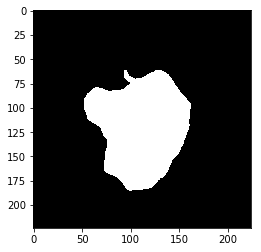

> Ground Truth

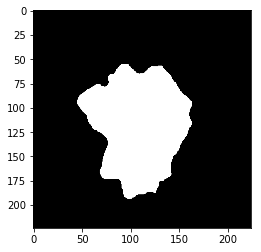

> Predicted mask

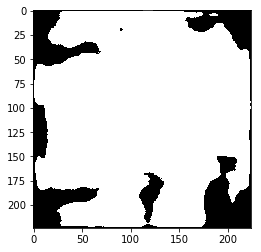

> Ground Truth

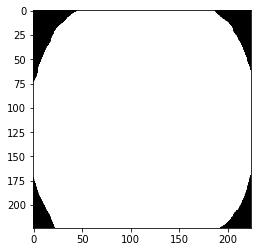

> Predicted mask

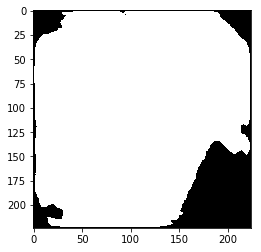

> Ground Truth

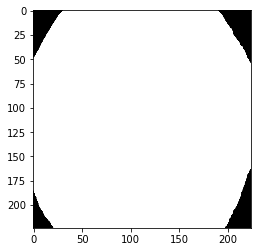

> Predicted mask

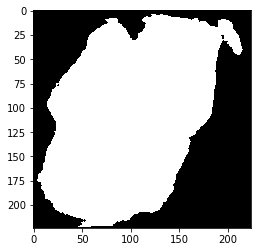

> Ground Truth

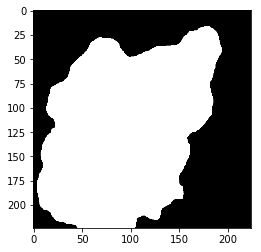

> Predicted mask

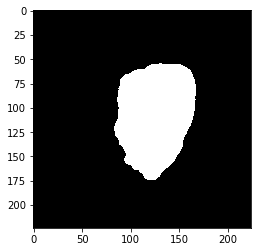

> Ground Truth

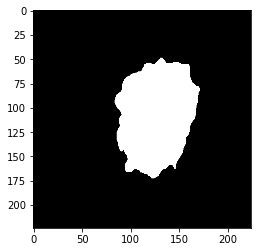

> Predicted mask

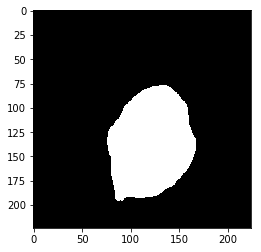

> Ground Truth

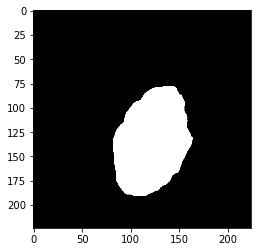

> Predicted mask

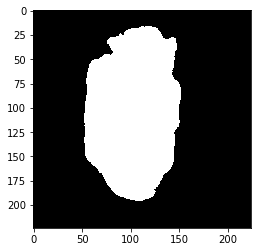

> Ground Truth

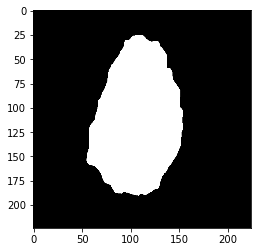

> Predicted mask

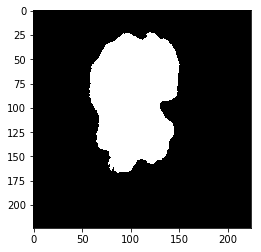

> Ground Truth

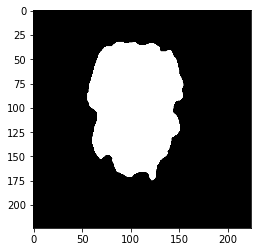

> Predicted mask

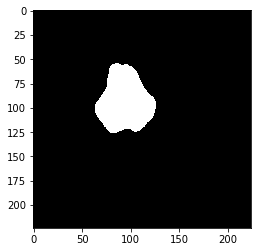

> Ground Truth

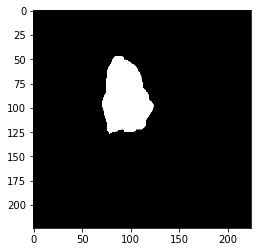

> Predicted mask

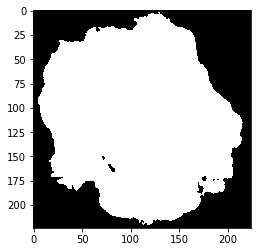

> Ground Truth

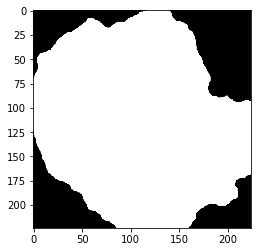

> Predicted mask

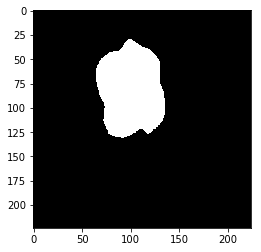

> Ground Truth

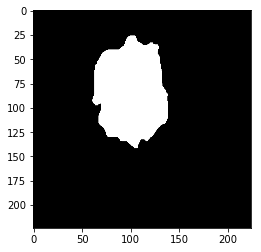

> Predicted mask

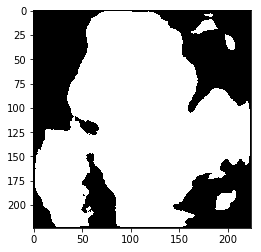

> Ground Truth

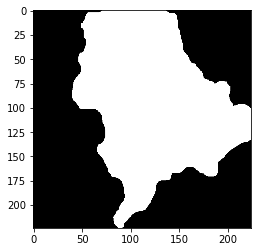

> Predicted mask

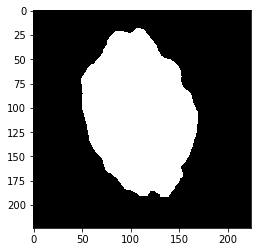

> Ground Truth

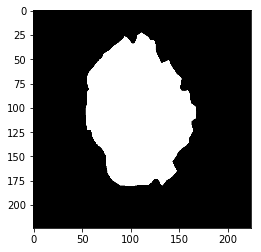

> Predicted mask

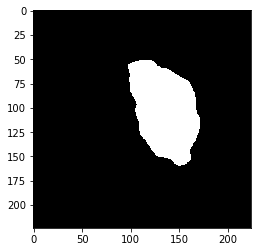

> Ground Truth

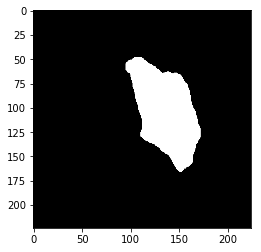

> Predicted mask

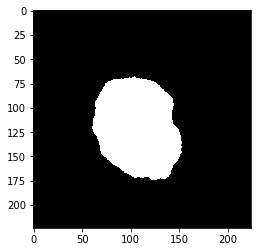

> Ground Truth

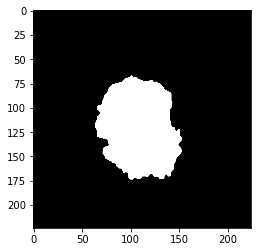

> Predicted mask

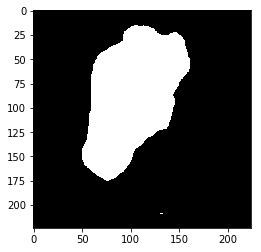

> Ground Truth

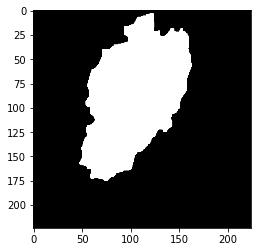

> Predicted mask

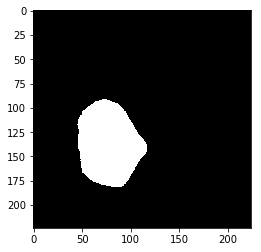

> Ground Truth

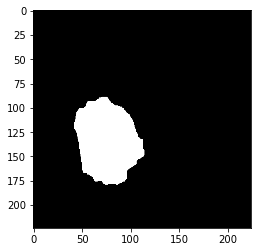

> Predicted mask

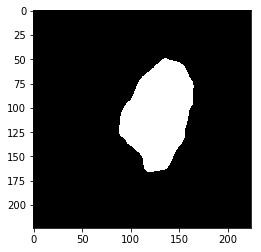

> Ground Truth

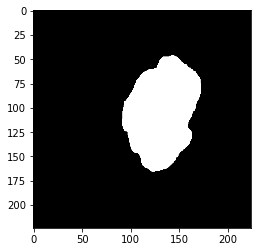

> Predicted mask

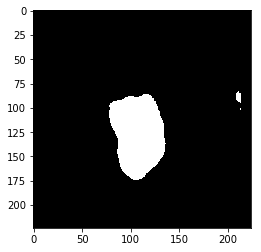

> Ground Truth

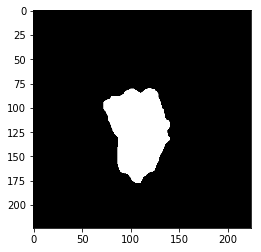

> Predicted mask

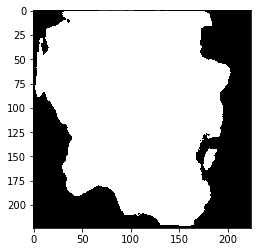

> Ground Truth

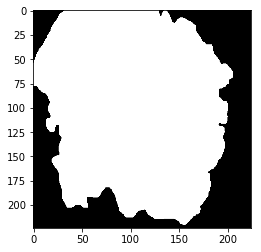

> Predicted mask

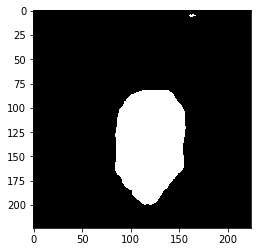

> Ground Truth

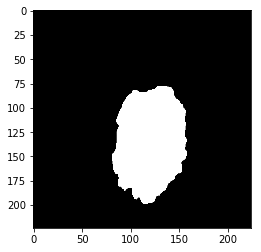

> Predicted mask

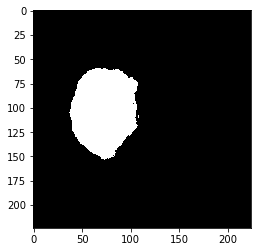

> Ground Truth

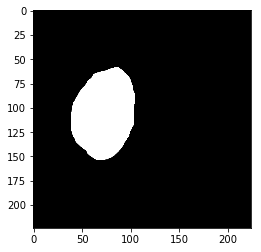

> Predicted mask

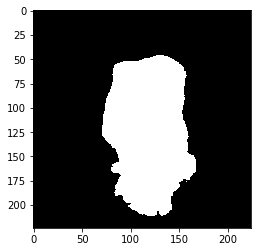

> Ground Truth

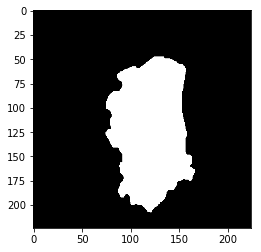

> Predicted mask

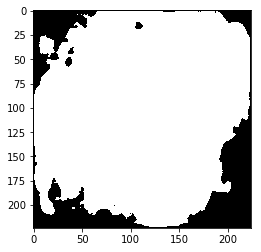

> Ground Truth

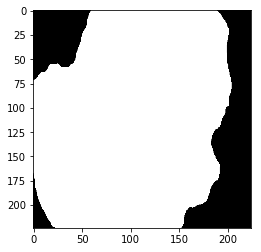

> Predicted mask

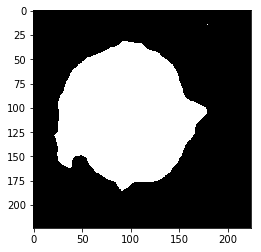

> Ground Truth

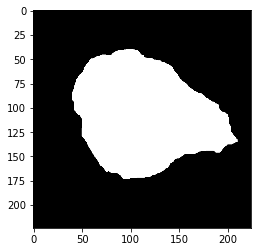

> Predicted mask

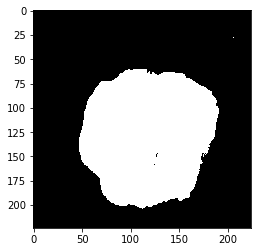

> Ground Truth

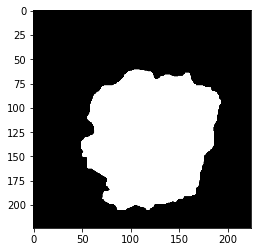

> Predicted mask

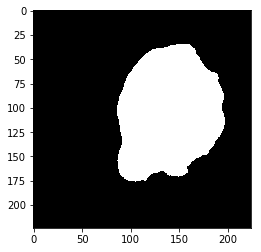

> Ground Truth

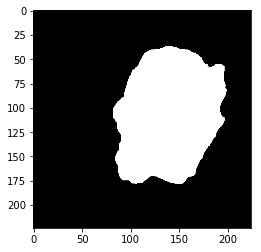

> Predicted mask

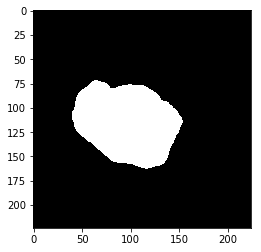

> Ground Truth

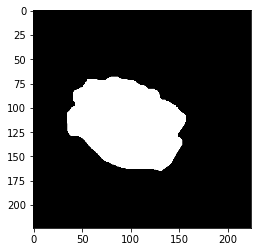

> Predicted mask

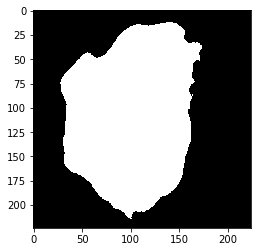

> Ground Truth

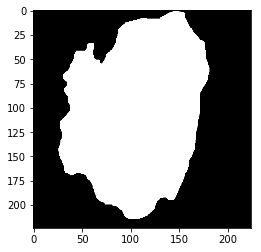

> Predicted mask

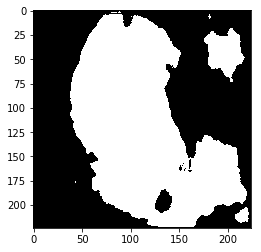

> Ground Truth

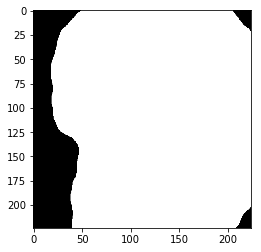

In [67]:
mask_score = []
for id in range(30):
    pred_score = pred_mask(id, True, True)
    mask_score.append(pred_score)

In [80]:
mask_score_sc = []
sess = tf.InteractiveSession()
for i in range(len(mask_score)):
    scalar = mask_score[i].eval()
    mask_score_sc.append(scalar)
# Other ops
sess.close()

In [89]:
mask_score_d = dict(enumerate(mask_score_sc))
sort_score = sorted(mask_score_d.items(), key = lambda mask_score_d: mask_score_d[1] )
print(sort_score)

[(29, 0.730177426569256), (11, 0.7956694058613919), (24, 0.8289162098160703), (6, 0.8823804513036362), (18, 0.8994373279061415), (8, 0.9006501083513919), (5, 0.9067722075637643), (7, 0.9075683285596389), (10, 0.9081547220361688), (3, 0.912163342299228), (9, 0.9136982375698525), (23, 0.9141341958778396), (17, 0.9165938517753595), (12, 0.9171321140437338), (13, 0.9195839910855232), (27, 0.9213178782915459), (22, 0.9239050760491112), (1, 0.9250556094222324), (0, 0.9257151645647493), (28, 0.9302172481895984), (21, 0.9311229726955451), (2, 0.9342929569286089), (15, 0.9380209446462919), (19, 0.942938003793267), (16, 0.9447123111539698), (26, 0.9464402085369827), (4, 0.947420115243583), (14, 0.9529639620944871), (25, 0.9544838709677419), (20, 0.9634716329905803)]


In [94]:
for i in range(len(sort_score)):
    print(sort_score[29-i][0],' ',sort_score[29-i][1])

20   0.9634716329905803
25   0.9544838709677419
14   0.9529639620944871
4   0.947420115243583
26   0.9464402085369827
16   0.9447123111539698
19   0.942938003793267
15   0.9380209446462919
2   0.9342929569286089
21   0.9311229726955451
28   0.9302172481895984
0   0.9257151645647493
1   0.9250556094222324
22   0.9239050760491112
27   0.9213178782915459
13   0.9195839910855232
12   0.9171321140437338
17   0.9165938517753595
23   0.9141341958778396
9   0.9136982375698525
3   0.912163342299228
10   0.9081547220361688
7   0.9075683285596389
5   0.9067722075637643
8   0.9006501083513919
18   0.8994373279061415
6   0.8823804513036362
24   0.8289162098160703
11   0.7956694058613919
29   0.730177426569256


In [91]:
print('Min Dice Score: ', sort_score[0][1], ' ID: ', sort_score[0][0])
print('Max Dice Score: ', sort_score[29][1], ' ID: ', sort_score[29][0])
print('Average Dice Score: ', sum(mask_score_sc)/len(mask_score_sc))

Min Dice Score:  0.730177426569256  ID:  29
Max Dice Score:  0.9634716329905803  ID:  20
Average Dice Score:  0.911170329206243


In [31]:
test  = cv2.imread('pred_5.png',0)

In [33]:
print(test.shape)
print(test.max()) # opencv max 255, pyplot max 1.0 (normalized)

(224, 224)
255


In [107]:
print(res.shape)
print(b.shape)
#dc = dice_coef(res,b)
#print(dc)

(224, 224)
(224, 224)


In [85]:
num_train = 170
def image_load():
    import cv2
    img_arr = []
    mask_arr = []
    for i in range(num_train):
        a = cv2.imread('data_seg/train/image/'+str(i)+'.png')
        a = cv2.resize(a, (224, 224)) 
        a = np.matrix.astype(a,dtype='float')
        img_arr.append(a)
        
        b = cv2.imread('data_seg/train/label/'+str(i)+'.png')
        b = cv2.resize(a, (224, 224)) 
        b = np.matrix.astype(a,dtype='float')
        mask_arr.append(b)
    return (img_arr, mask_arr)   
        

In [86]:
(img_arr, mask_arr) = image_load()

In [87]:
print(len(img_arr))

170


In [88]:
img_arr2 = []

In [89]:
img_arr2 = img_arr

In [90]:
print(len(img_arr2))

170


In [58]:
test = 0
def phi():
    global test
    test += 5
    print(test)


In [135]:
def batch_generator(batch_size):
    while True:
        image_list = []
        mask_list = []
        for i in range(batch_size):
            img, mask = gen_random_image(i)
            image_list.append(img)
            mask_list.append([mask])
  

        image_list = np.array(image_list, dtype=np.float32)
        
        if K.image_dim_ordering() == 'th':
            image_list = image_list.transpose((0, 3, 1, 2))
        image_list = preprocess_input(image_list)
        mask_list = np.array(mask_list, dtype=np.float32)
        print(image_list.shape)
        print(mask_list.shape)
        mask_list /= 255.0
        yield image_list, mask_list

In [131]:
a = [12,345,56]
a = np.array(a, dtype = np.float)
print(a.shape)

(3,)


In [57]:
# coding: utf-8
'''
    - train "ZF_UNET_224" CNN with random images, modified by zabir
'''

import os
import cv2
import random
import numpy as np
import pandas as pd
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import __version__
from zf_unet_224_model import *

print('Entering ...')
img_arr = []
mask_arr = []
num_train = 4
global gen_batch 

def gen_random_image():
    global gen_batch 
    img = img_arr[gen_batch]
    mask = mask_arr[gen_batch]
    gen_batch += 1
    if gen_batch >= num_train:
        gen_batch = 0
    



    return img, mask


def batch_generator(batch_size):
    while True:
        image_list = []
        mask_list = []
        for i in range(batch_size):
            img, mask = gen_random_image()
            image_list.append(img)
            mask_list.append([mask])

        image_list = np.array(image_list, dtype=np.float32)
        if K.image_dim_ordering() == 'th':
            image_list = image_list.transpose((0, 3, 1, 2))
        image_list = preprocess_input(image_list)
        mask_list = np.array(mask_list, dtype=np.float32)
        mask_list /= 255.0
        yield image_list, mask_list


def train_unet():
    out_model_path = 'zf_unet_224.h5'
    epochs = 1
    patience = 20
    batch_size = 2
    optim_type = 'SGD'
    learning_rate = 0.001
    model = ZF_UNET_224()
    if os.path.isfile(out_model_path):
        model.load_weights(out_model_path)

    if optim_type == 'SGD':
        optim = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
    else:
        optim = Adam(lr=learning_rate)
    model.compile(optimizer=optim, loss=dice_coef_loss, metrics=[dice_coef])

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, epsilon=0.00001, verbose=1, mode='min'),
        # EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
        ModelCheckpoint('zf_unet_224_temp.h5', monitor='val_loss', save_best_only=True, verbose=0),
    ]

    print('Start training...')
    history = model.fit_generator(
        generator=batch_generator(batch_size),
        epochs=epochs,
        steps_per_epoch=4,
        validation_data=batch_generator(batch_size),
        validation_steps=4,
        verbose=2,
        callbacks=callbacks)

    model.save_weights(out_model_path)
    pd.DataFrame(history.history).to_csv('zf_unet_224_train.csv', index=False)
    print('Training is finished (weights zf_unet_224.h5 and log zf_unet_224_train.csv are generated )...')



import cv2

for i in range(num_train):
    a = cv2.imread('data_seg/train/image/'+str(i)+'.png')
    a = cv2.resize(a, (224, 224)) 
    a = np.array(a,dtype=np.uint8)
    img_arr.append(a)

    b = cv2.imread('data_seg/train/label/'+str(i)+'.png',0)
    b = cv2.resize(b, (224, 224)) 
    b = np.array(b,dtype=np.uint8)
    mask_arr.append(b)
gen_batch = 0

Entering ...


In [20]:
train_unet()

Start training...
Epoch 1/1
 - 148s - loss: -1.4536e-01 - dice_coef: 0.1454 - val_loss: -1.2648e-01 - val_dice_coef: 0.1265
Training is finished (weights zf_unet_224.h5 and log zf_unet_224_train.csv are generated )...


### References:
1. https://github.com/ZFTurbo/ZF_UNET_224_Pretrained_Model
2. https://stackoverflow.com/questions/36288670/how-to-programmatically-generate-markdown-output-in-jupyter-notebooks
3. https://stackoverflow.com/questions/37049411/tensorflow-how-to-convert-scalar-tensor-to-scalar-variable-in-python